In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the Dataset
file_path = "D:\\MapApp\\Churn_Modelling.csv"  # Adjust path if needed
df = pd.read_csv(file_path)
print("Original Data Shape:", df.shape)

# 2. Drop Irrelevant Columns
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

# 3. Separate Features (X) and Target (y)
X = df.drop("Exited", axis=1)
y = df["Exited"]

Original Data Shape: (10000, 14)


In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify Categorical & Numerical
categorical_cols = ["Geography", "Gender"]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# One-Hot + Scale
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
])

X_transformed = preprocessor.fit_transform(X)
print("Shape after encoding & scaling:", X_transformed.shape)

# Reshape for BiLSTM (samples, timesteps=1, features)
n_samples = X_transformed.shape[0]
n_features = X_transformed.shape[1]
X_reshaped = X_transformed.reshape((n_samples, 1, n_features))
print("Shape after reshaping for BiLSTM:", X_reshaped.shape)

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Shape after encoding & scaling: (10000, 11)
Shape after reshaping for BiLSTM: (10000, 1, 11)
Train shape: (8000, 1, 11) Test shape: (2000, 1, 11)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.metrics import Precision, Recall

# Build Model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu'), input_shape=(1, n_features)),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with extra metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()

C:\Users\chand\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        38,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,041 (152.50 KB)

 Trainable params: 39,041 (152.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# (Optional) EarlyStopping to reduce overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=35,         # Adjust as needed
    batch_size=32,     # Adjust as needed
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7682 - loss: 0.5630 - precision: 0.1453 - recall: 0.0236 - val_accuracy: 0.8200 - val_loss: 0.4086 - val_precision: 0.7089 - val_recall: 0.1425
Epoch 2/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8300 - loss: 0.4083 - precision: 0.7675 - recall: 0.2138 - val_accuracy: 0.8505 - val_loss: 0.3654 - val_precision: 0.7238 - val_recall: 0.3868
Epoch 3/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8510 - loss: 0.3707 - precision: 0.7610 - recall: 0.4233 - val_accuracy: 0.8595 - val_loss: 0.3487 - val_precision: 0.7393 - val_recall: 0.4402
Epoch 4/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8607 - loss: 0.3520 - precision: 0.7712 - recall: 0.4482 - val_accuracy: 0.8615 - val_loss: 0.3438 - val_precision: 0.7417 - val_recall: 0.4529
Epoch 5/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8488 - loss: 0.3583 - precision: 0.7207 - recall: 0.4345 - val_accuracy: 0.8590 - val_loss: 0.

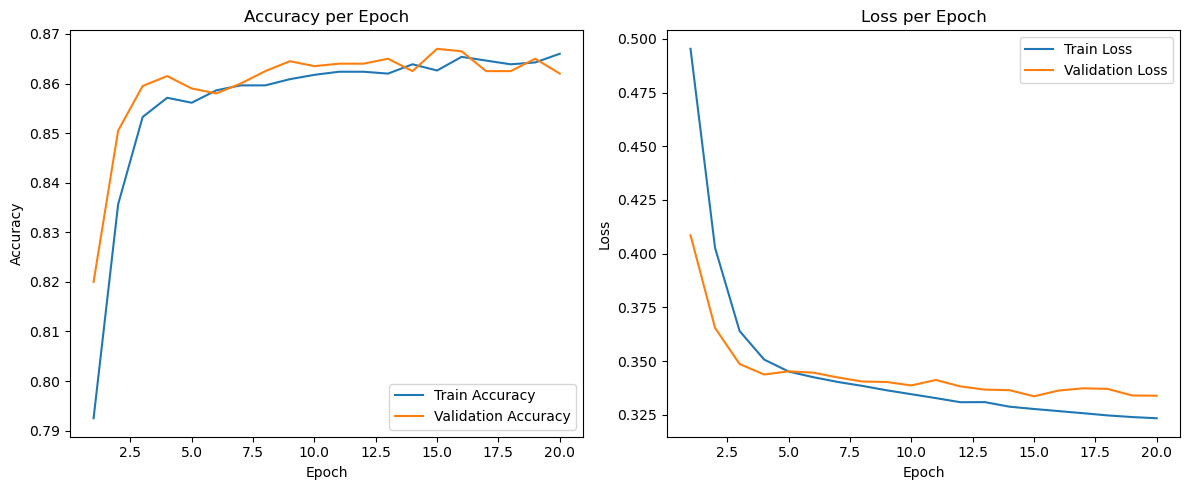

In [17]:
import matplotlib.pyplot as plt

# 1. Extract values from the history object
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

# 2. Create an epoch range for the x-axis
epochs = range(1, len(train_acc) + 1)

# 3. Plot Accuracy (left subplot)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 4. Plot Loss (right subplot)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss     : {loss:.4f}")
print(f"Final Test Accuracy : {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall   : {recall:.4f}")
print(f"Test F1 Score : {2 * (precision * recall) / (precision + recall):.4f}")

Test Loss     : 0.3336
Final Test Accuracy : 0.8670
Test Precision: 0.7797
Test Recall   : 0.4504
Test F1 Score : 0.5710


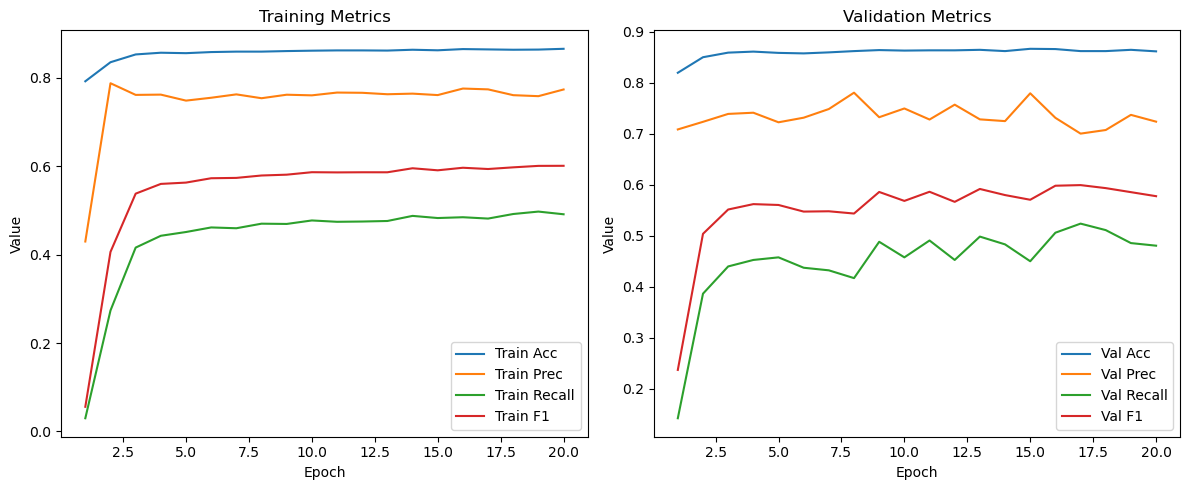

In [19]:
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']

val_accuracy = history.history['val_accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

# Manually compute F1 from precision & recall
def compute_f1(precisions, recalls):
    f1_scores = []
    for p, r in zip(precisions, recalls):
        if (p + r) == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(2 * p * r / (p + r))
    return f1_scores

train_f1 = compute_f1(train_precision, train_recall)
val_f1   = compute_f1(val_precision, val_recall)

# Plot Accuracy, Precision, Recall, F1 over Epochs
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 5))

# --- Training Metrics ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Acc')
plt.plot(epochs, train_precision, label='Train Prec')
plt.plot(epochs, train_recall, label='Train Recall')
plt.plot(epochs, train_f1, label='Train F1')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

# --- Validation Metrics ---
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, label='Val Acc')
plt.plot(epochs, val_precision, label='Val Prec')
plt.plot(epochs, val_recall, label='Val Recall')
plt.plot(epochs, val_f1, label='Val F1')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

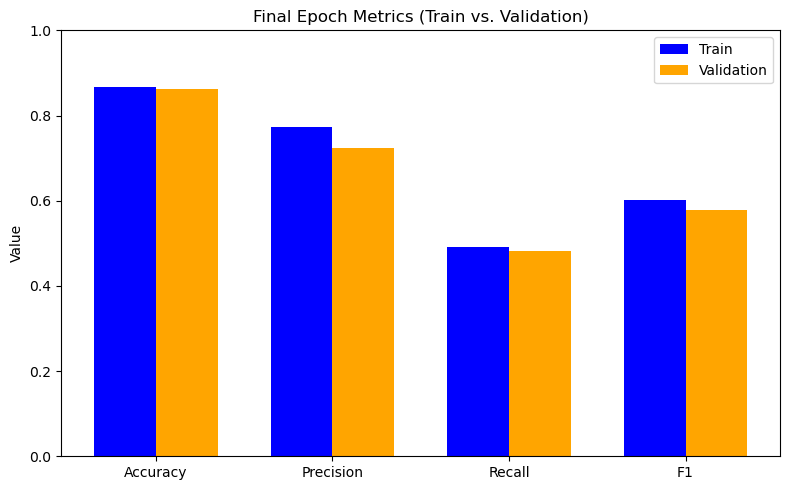

In [20]:
final_train_acc = train_accuracy[-1]
final_train_prec = train_precision[-1]
final_train_rec = train_recall[-1]
final_train_f1 = train_f1[-1]

final_val_acc = val_accuracy[-1]
final_val_prec = val_precision[-1]
final_val_rec = val_recall[-1]
final_val_f1 = val_f1[-1]

metrics = ["Accuracy", "Precision", "Recall", "F1"]
train_values = [final_train_acc, final_train_prec, final_train_rec, final_train_f1]
val_values   = [final_val_acc,   final_val_prec,   final_val_rec,   final_val_f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, train_values, width, label='Train', color='blue')
plt.bar(x + width/2, val_values,   width, label='Validation', color='orange')

plt.xticks(x, metrics)
plt.ylim([0, 1])  # Typically in [0, 1]
plt.ylabel('Value')
plt.title('Final Epoch Metrics (Train vs. Validation)')
plt.legend()
plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


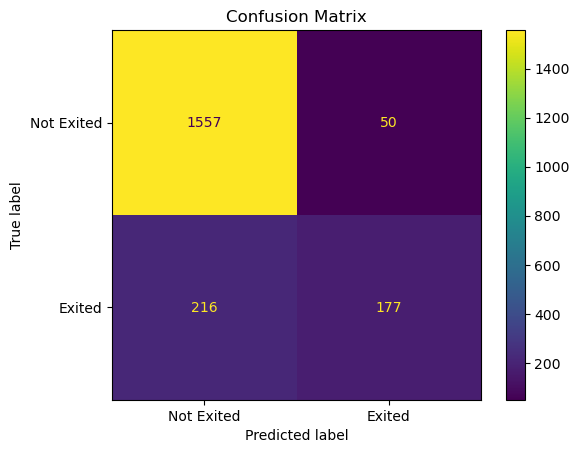

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Not Exited", "Exited"])
plt.title("Confusion Matrix")
plt.show()